In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler

In [66]:
def r_adjusted(r_squared, X, y):
    return 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)

# Initial Inspection

In [67]:
# Read in the csv file which contains data
df = pd.read_csv('kc_house_data.csv')

In [68]:
# Let's take a look at the first few columns
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [69]:
# Let's look at the data types. Note that date and sqft_basement are string object.
print(df.dtypes)
print('Dataframe shape',df.shape)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
Dataframe shape (21597, 21)


In [70]:
'''
Get the number of NAs for a DataFrame, and the percentage of NAs in the data
'''

def print_NAs(dataframe):
    for column in dataframe:
        num_nas = dataframe[column].isna().sum()
        if num_nas > 0:
            print('Found {0} \t NAs in column \t{1} ({2:0.2f}% of the data)'.format(num_nas, column, 100.*num_nas/len(df)))

print_NAs(df)

Found 2376 	 NAs in column 	waterfront (11.00% of the data)
Found 63 	 NAs in column 	view (0.29% of the data)
Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


# Plot the waterfront locations on a graph
Not shown here because of library issues but include in powerpoint

In [71]:
# From looking at the map, we found some waterfont properties labeled as NAs that had a water front view.
# Correctly assigning the NAs, requires a deeper analysis. 
# Se decided to drop this column
#df = df.drop(columns=["waterfront"])

In [72]:
# "view" column has empty values, will fill with mode
view_mode = df['view'].mode()
print(view_mode[0])
df['view'].fillna(value=view_mode[0],inplace=True)

0.0


In [73]:
# year renovated is ~18% of the data, 
#Convert year renovated to renovated or not variable
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

In [74]:
#sqft basement is a string and some values are missing '?'
df['sqft_basement'].head(7) 

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [75]:
# the basement sqft can be calculated as the difference 
# between the living area and the above area
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
#

In [76]:
# but since sqft_basement is dependent on two other variables, lets remove it and
# let's convert it into a has basement or not
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)


In [77]:
# Looking for outliers

In [78]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

In [79]:
df[df.bedrooms>30]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0,1


In [80]:
# The 33 bedroom house appears to be a typo as the property has only 1.75 bathrooms, removing..
df = df[df.bedrooms<30]

#### Most houses are sold on Tuesdays! Who is buying on a weekend?

### New/Renovated Housing vs. Price
Can how recently a house was built or renovated—it's "newness"—affect it's price per square foot?

In [81]:
df["blt_or_renov"] = df["yr_renovated"]
df.loc[df[df["blt_or_renov"] == 0].index, "blt_or_renov"] = df[df["blt_or_renov"] ==0]["yr_built"]
df["blt_or_renov"].fillna(value=df["yr_built"], inplace=True)

In [82]:
df["price_per_sqft"] = df["price"]/df["sqft_living"]

## Modelling whole data set

In [83]:
columns_to_drop = ['id', 'date']
#columns_to_drop = ['id', 'zipcode','lat','long',\
#                   'date', 'sqft_basement' , 'yr_renovated','price_per_sqft', 'blt_or_renov']
# We are removing these columns as the seller is not is control of this variables


In [84]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [85]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement,blt_or_renov,price_per_sqft
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,...,0.0,98178,47.5112,-122.257,1340,5650,0,0,1955.0,188.050847
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,1991.0,98125,47.7210,-122.319,1690,7639,1,1,1991.0,209.338521
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,NaN,98028,47.7379,-122.233,2720,8062,0,0,1933.0,233.766234
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,0.0,98136,47.5208,-122.393,1360,5000,0,1,1965.0,308.163265
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,0.0,98074,47.6168,-122.045,1800,7503,0,0,1987.0,303.571429


In [86]:
# Dropping additional columns
# year_bought is all effectively 2014 and 2015. 
# sqft_living15 and sqft_lot15 only has correlations to sqft, 
# which is a more representative variable
#more_cols_to_drop = ['year_bought', 'sqft_lot15', 'sqft_living15']

In [87]:
#df.drop(more_cols_to_drop, axis=1, inplace=True)

# Standardize the data

In [88]:
b = df['sqft_living']
sqft_living_min = min(b)
sqft_living_range = max(b)-min(b)
df['sqft_living'] = (b-sqft_living_min)/sqft_living_range

b = df['sqft_above']
sqft_ab_min = min(b)
sqft_ab_range = max(b)-min(b)
df['sqft_above'] = (b-sqft_ab_min)/(sqft_ab_range)

b = df['sqft_lot']
sqft_lot_min = min(b)
sqft_lot_range = max(b)-min(b)
df['sqft_lot'] = (b-sqft_lot_min)/(sqft_lot_range)

b = df['sqft_living15']
sqft_living15_min = min(b)
sqft_living15_range = max(b)-min(b)
df['sqft_living15'] = (b-sqft_living15_min)/sqft_living15_range

b = df['sqft_lot15']
sqft_lot15_min = min(b)
sqft_lot15_range = max(b)-min(b)
df['sqft_lot15'] = (b-sqft_lot15_min)/sqft_lot15_range

b = df['sqft_basement']
sqft_basement_min = min(b)
sqft_basement_range = max(b)-min(b)
df['sqft_basement'] = (b-sqft_basement_min)/sqft_basement_range

b = df['yr_built']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_built'] = (b-yb_min)/(yb_range)

b = df['yr_renovated']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_renovated'] = (b-yb_min)/(yb_range)

# standardization
b = df['price']
y = np.log(b)
# price_mean = b.mean()
# price_std = b.std()
# y = (b-price_mean)/(price_std)


In [89]:
zip_dummy = pd.get_dummies(df["zipcode"], prefix="ZIP")
df = df.drop(columns=["zipcode"],)
df = pd.concat([df, zip_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [90]:
wf_dummy = pd.get_dummies(df["waterfront"], prefix="WF")
df = df.drop(columns=["waterfront"],)
df = pd.concat([df, wf_dummy], axis=1)

In [91]:
view_dummy = pd.get_dummies(df["view"], prefix="VIEW")
df = df.drop(columns=["view"],)
df = pd.concat([df, view_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [92]:
condition_dummy = pd.get_dummies(df["condition"], prefix="COND")
df = df.drop(columns=["condition"],)
df = pd.concat([df, condition_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [93]:
grade_dummy = pd.get_dummies(df["grade"], prefix="GRADE")
df = df.drop(columns=["grade"],)
df = pd.concat([df, grade_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [94]:
print_NAs(df)

Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


In [95]:
df.drop("yr_renovated", axis=1, inplace=True)

In [96]:
#from sklearn.cluster import SpectralClustering
#model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',
#                           assign_labels='kmeans')
#labels = model.fit_predict(X)

In [97]:
#Lets select our predictor data frame
X = df.drop(columns=['price', "price_per_sqft"])

In [98]:
# Let's split the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print('Train length ',len(X_train), len(y_train))
print('Test length ',len(X_test), len(y_test))

Train length  17276 17276
Test length  4320 4320


In [99]:
from sklearn.linear_model import Ridge
linreg = Ridge(alpha=.5)
linreg.fit(X_train, y_train)
#model = sm.OLS(y_train, sm.add_constant(X_train[fields])).fit()
#model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [100]:
linreg.score(X_train, y_train)

0.8795327355722827

In [101]:
r_squared = linreg.score(X_train, y_train)

adj = r_adjusted(r_squared, X, y)

In [102]:
adj

0.8789497661664625

In [103]:
from sklearn.metrics import r2_score
y_predict = linreg.predict(X_test)

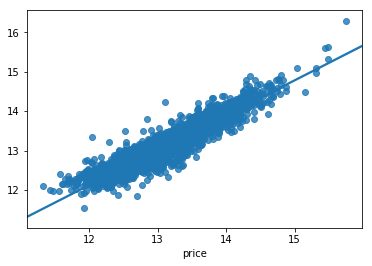

In [104]:
sns.regplot(y_test, y_predict)

In [105]:
r2_score(y_predict, y_test)

0.864488507917138

In [106]:
y_predict_train = linreg.predict(X_train)
print(r2_score(y_predict_train, y_train))
print(r2_score(y_predict, y_test))

0.8626246121904477
0.864488507917138


In [107]:
y_predict_train = linreg.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.033417948298497334
Test Mean Squarred Error: 0.03352606591169623
1.0032353157121785


In [108]:
model_results = []
model_results.append(["Ridge - alpha .5", linreg.score(X_train, y_train), adj, train_mse, test_mse])

In [109]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [110]:
lasso.score(X_train, y_train)

0.009877546085634847

In [111]:
y_predict_train = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.27466267397434707
Test Mean Squarred Error: 0.03352606591169623
0.1220626939459109


In [112]:
#adj = r_adjusted(lasso.score(X_train, y_train), X, y)
#model_results.append(["Lasso - alpha 1", lasso.score(X_train, y_train), adj, train_mse, test_mse])

In [113]:
lasso = Lasso(alpha=.001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [114]:
lasso.score(X_train, y_train)

0.8462704892712468

In [115]:
r2_score(y_predict, y_test)

0.864488507917138

In [116]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [117]:
alphas = np.logspace(-3, -1, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)

In [118]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([0.001  , 0.00117, 0.00137, 0.00161, 0.00189, 0.00221, 0.00259,
       0.00304, 0.00356, 0.00418, 0.00489, 0.00574, 0.00672, 0.00788,
       0.00924, 0.01083, 0.01269, 0.01487, 0.01743, 0.02043, 0.02395,
       0.02807, 0.0329 , 0.03857, 0.0452 , 0.05298, 0.0621 , 0.07279,
       0.08532, 0.1    ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

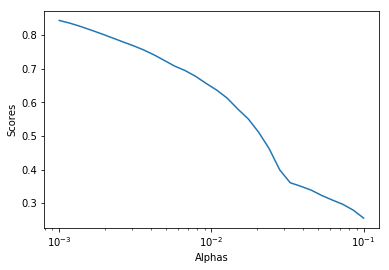

In [119]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [120]:
lasso = Lasso(alpha=.0001)
lasso.fit(X_train, y_train)
lasso.score(X_train, y_train)

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.8781530184190544

In [121]:
from sklearn.metrics import mean_squared_error
y_predict_train = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.0338006856065301
Test Mean Squarred Error: 0.03352606591169623
0.9918753217603132


In [122]:
adj = r_adjusted(lasso.score(X_train, y_train), X_train, y_train)
model_results.append(["Lasso - alpha .0001", lasso.score(X_train, y_train), adj, train_mse, test_mse])

In [125]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001, l1_ratio=.00001)
elastic.fit(X_train, y_train)

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [126]:

alphas = np.logspace(-3, -1, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(elastic, tuned_parameters, cv=n_folds, refit=False)

In [127]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([0.001  , 0.00117, 0.00137, 0.00161, 0.00189, 0.00221, 0.00259,
       0.00304, 0.00356, 0.00418, 0.00489, 0.00574, 0.00672, 0.00788,
       0.00924, 0.01083, 0.01269, 0.01487, 0.01743, 0.02043, 0.02395,
       0.02807, 0.0329 , 0.03857, 0.0452 , 0.05298, 0.0621 , 0.07279,
       0.08532, 0.1    ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

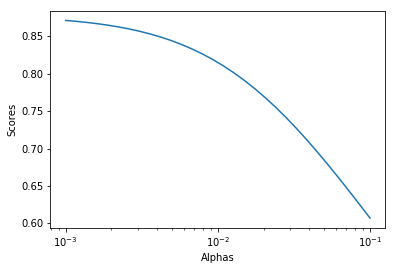

In [128]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [129]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [130]:
from sklearn.metrics import mean_squared_error
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.033642159207380215
Test Mean Squarred Error: 0.03352606591169623
0.9965491722761209


In [131]:
elastic.score(X_train, y_train)

0.878724485029589

In [132]:
L1_ratios = np.linspace(0, 1, 3)

tuned_parameters = [{'l1_ratio': L1_ratios}]
n_folds = 3

clf = GridSearchCV(elastic, tuned_parameters, cv=n_folds, refit=False)

In [133]:
clf.fit(X_train, y_train)

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceW

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'l1_ratio': array([0. , 0.5, 1. ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

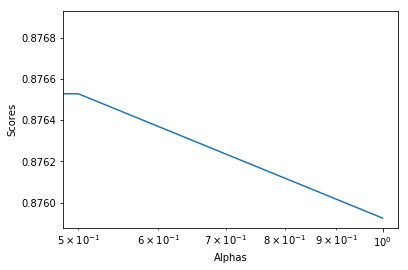

In [134]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(L1_ratios, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [135]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001, l1_ratio=.00001)
elastic.fit(X_train, y_train)

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [136]:
elastic.score(X_train, y_train)

0.8791185367336701

In [137]:
from sklearn.metrics import mean_squared_error
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03353284818802179
Test Mean Squarred Error: 0.03352606591169623
0.9997977423126265


In [138]:
cvs = cross_val_score(lasso, X_train, y_train, cv=20, scoring="neg_mean_squared_error")

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceW

In [139]:
cvs

array([-0.03006311, -0.03261812, -0.03896727, -0.0350196 , -0.0330233 ,
       -0.0355047 , -0.03493951, -0.03565573, -0.03326498, -0.03417268,
       -0.03341666, -0.03402589, -0.03853428, -0.03531093, -0.03412243,
       -0.03813275, -0.03375685, -0.03009457, -0.03184345, -0.03386593])

In [140]:
cvs = cross_val_score(lasso, X_train, y_train, cv=20, scoring="r2")

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceW

In [141]:
cvs

array([0.88871708, 0.89025602, 0.85562645, 0.86707827, 0.87755007,
       0.86542407, 0.8741497 , 0.86163961, 0.88592411, 0.88620529,
       0.88111496, 0.87540925, 0.87312009, 0.871835  , 0.87744822,
       0.85840567, 0.86997336, 0.89131386, 0.88685219, 0.88014015])

In [142]:
lasso.coef_

array([-3.19588167e-03,  4.11515434e-02,  1.18012040e+00,  8.24850281e-01,
       -2.59364458e-02,  1.13269336e+00,  0.00000000e+00, -8.96056669e-02,
        1.20034987e+00, -4.20917184e-01,  4.84928088e-01,  1.22419237e-02,
        6.54070219e-02,  4.61323018e-02, -4.37758325e-05, -2.64195576e-01,
       -2.60004255e-01, -2.83999301e-01,  4.75911308e-01,  1.18014345e-01,
        9.99355888e-02,  3.54315794e-02,  5.60878891e-02,  5.71754726e-02,
       -3.28190714e-01, -1.99969965e-01, -3.08477503e-01,  0.00000000e+00,
       -3.40587284e-01,  0.00000000e+00,  5.23861143e-02, -3.81552019e-01,
        1.15736571e-01, -2.46521935e-01, -2.75297229e-01, -3.72669470e-01,
        8.59576997e-02, -2.03659813e-01, -7.04878748e-02,  5.70823748e-01,
        2.90204932e-01, -2.09571138e-01,  6.97900760e-02, -3.09046903e-02,
       -3.27342150e-02, -2.85064297e-01, -1.59290514e-01, -2.27371778e-01,
       -1.06962511e-01,  1.07801924e-02, -1.25377917e-01, -2.54983082e-01,
       -1.43547594e-02,  

In [143]:
list(zip(lasso.coef_, X_train.columns))

[(-0.0031958816726035824, 'bedrooms'),
 (0.04115154344237766, 'bathrooms'),
 (1.1801204038247601, 'sqft_living'),
 (0.8248502809187578, 'sqft_lot'),
 (-0.025936445762302224, 'floors'),
 (1.132693359348286, 'sqft_above'),
 (0.0, 'sqft_basement'),
 (-0.08960566686942242, 'yr_built'),
 (1.2003498749567465, 'lat'),
 (-0.42091718428799135, 'long'),
 (0.4849280879234004, 'sqft_living15'),
 (0.012241923673515906, 'sqft_lot15'),
 (0.06540702190908614, 'is_renovated'),
 (0.04613230179968735, 'has_basement'),
 (-4.3775832460805205e-05, 'blt_or_renov'),
 (-0.2641955755509215, 'ZIP_98001'),
 (-0.26000425491488094, 'ZIP_98002'),
 (-0.28399930055092243, 'ZIP_98003'),
 (0.4759113080456344, 'ZIP_98004'),
 (0.11801434519256936, 'ZIP_98005'),
 (0.09993558877629423, 'ZIP_98006'),
 (0.03543157943942589, 'ZIP_98007'),
 (0.0560878890920632, 'ZIP_98008'),
 (0.05717547258503321, 'ZIP_98010'),
 (-0.3281907136340642, 'ZIP_98011'),
 (-0.19996996503383505, 'ZIP_98014'),
 (-0.3084775030962625, 'ZIP_98019'),
 (0.0,

In [144]:
coefs = list(zip(lasso.coef_, X_train.columns))

In [145]:
coefs = [x for x in coefs if "ZIP" in x[1]]

In [146]:
coefs.sort(key=lambda x: x[0])

In [147]:
coefs

[(-0.41819470466146025, 'ZIP_98168'),
 (-0.4000505272333591, 'ZIP_98155'),
 (-0.38155201909185027, 'ZIP_98028'),
 (-0.374260859138273, 'ZIP_98133'),
 (-0.37266946983539506, 'ZIP_98032'),
 (-0.340587283571668, 'ZIP_98023'),
 (-0.3359288777995411, 'ZIP_98178'),
 (-0.3353695056943485, 'ZIP_98198'),
 (-0.3281907136340642, 'ZIP_98011'),
 (-0.3201594523856663, 'ZIP_98188'),
 (-0.3084775030962625, 'ZIP_98019'),
 (-0.28506429654556814, 'ZIP_98055'),
 (-0.28399930055092243, 'ZIP_98003'),
 (-0.27529722875558416, 'ZIP_98031'),
 (-0.2752840807752812, 'ZIP_98146'),
 (-0.2641955755509215, 'ZIP_98001'),
 (-0.26164552427218674, 'ZIP_98148'),
 (-0.26000425491488094, 'ZIP_98002'),
 (-0.254983081983648, 'ZIP_98072'),
 (-0.2510854462136573, 'ZIP_98106'),
 (-0.25101123746241677, 'ZIP_98177'),
 (-0.2465219346565643, 'ZIP_98030'),
 (-0.24611969843826118, 'ZIP_98077'),
 (-0.2349785294682819, 'ZIP_98108'),
 (-0.2273717782181644, 'ZIP_98058'),
 (-0.21772327627475144, 'ZIP_98125'),
 (-0.2095711383167418, 'ZIP_98

In [148]:
adj = r_adjusted(elastic.score(X_train, y_train), X_train, y_train)
model_results.append(["Elastic - alpha=.0001, l1_ratio=.00001", elastic.score(X_train, y_train), adj, train_mse, test_mse])

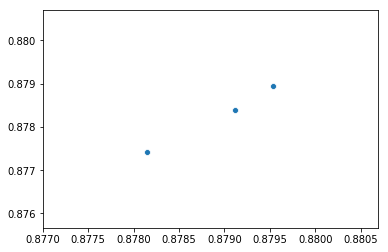

In [149]:


r2 = [x[1] for x in model_results]
r2_adj = [x[2] for x in model_results]
sns.scatterplot(r2, r2_adj)

In [150]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [151]:
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03353284818802179
Test Mean Squarred Error: 0.03352606591169623
0.9997977423126265


In [152]:
linreg.score(X_train, y_train)

0.8796362504869404

In [153]:
adj = r_adjusted(linreg.score(X_train, y_train), X_train, y_train)

In [154]:
model_results.append(["Linear Regression", linreg.score(X_train, y_train), adj, train_mse, test_mse])

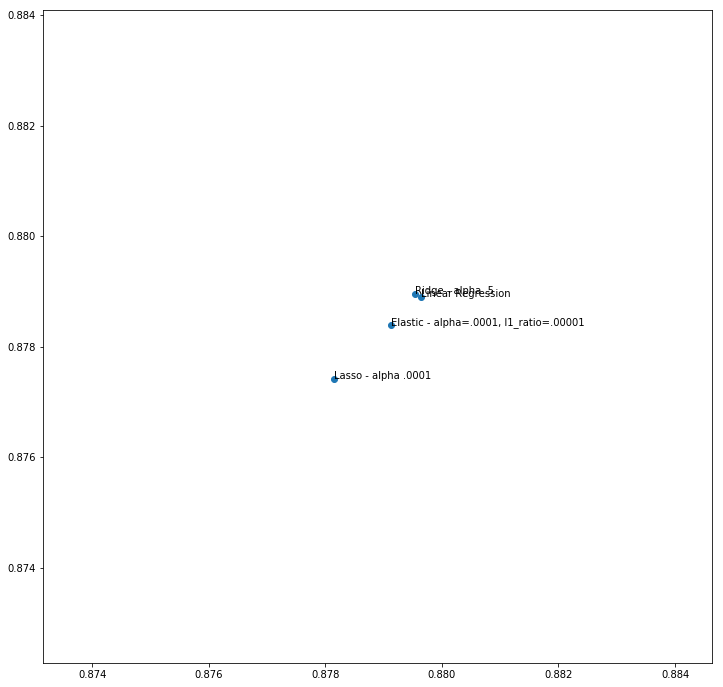

In [159]:


r2 = [x[1] for x in model_results]
r2_adj = [x[2] for x in model_results]
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(r2, r2_adj)

for i, entry in enumerate(model_results):
    ax.annotate(entry[0], (r2[i], r2_adj[i]))

#ax.margins(x=0, y=-0.45)


In [156]:
model_results

[['Ridge - alpha .5',
  0.8795327355722827,
  0.8789497661664625,
  0.033417948298497334,
  0.03352606591169623],
 ['Lasso - alpha .0001',
  0.8781530184190544,
  0.8774150249367634,
  0.0338006856065301,
  0.03352606591169623],
 ['Elastic - alpha=.0001, l1_ratio=.00001',
  0.8791185367336701,
  0.8783863911288889,
  0.03353284818802179,
  0.03352606591169623],
 ['Linear Regression',
  0.8796362504869404,
  0.8789072405312384,
  0.03353284818802179,
  0.03352606591169623]]

In [157]:
print("Ratio of MSEs")
["%s - %s" % (x[0], x[3]/x[4]) for x in model_results]

Ratio of MSEs


['Ridge - alpha .5 - 0.9967751177998734',
 'Lasso - alpha .0001 - 1.008191229342482',
 'Elastic - alpha=.0001, l1_ratio=.00001 - 1.0002022986038213',
 'Linear Regression - 1.0002022986038213']